In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(6,6)}) 
%matplotlib inline

In [4]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/data/heart.csv')

In [6]:
#Getting rid of NAN
df = df[df["Cholesterol"] > 0]

In [7]:
#Convert Strings to INT
# Sex: The person’s sex (1 = male, 0 = female)
df["Sex"] = (df["Sex"] == "F").astype("int")

#cp: chest pain type
# Value 0: asymptomatic ASY
# Value 1: atypical angina ATA
# Value 2: non-anginal pain NAP
# Value 3: typical angina TA

df.loc[df.ChestPainType == "ASY","ChestPainType"] = 0
df.loc[df.ChestPainType == "ATA","ChestPainType"] = 1
df.loc[df.ChestPainType == "NAP","ChestPainType"] = 2
df.loc[df.ChestPainType == "TA","ChestPainType"] = 3


#restecg: resting electrocardiographic results
# Value 0: showing probable or definite left ventricular hypertrophy(LVH)
# Value 1: normal
# Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

df.loc[df.RestingECG == "LVH","RestingECG"] = 0
df.loc[df.RestingECG == "Normal","RestingECG"] = 1
df.loc[df.RestingECG == "ST","RestingECG"] = 2


# exang: Exercise induced angina (1 = yes; 0 = no)
df["ExerciseAngina"] = (df["ExerciseAngina"] == "Y").astype("int")

#slope: the slope of the peak exercise ST segment — 0: downsloping; 1: flat; 2: upsloping

df.loc[df.ST_Slope == "Down","ST_Slope"] = 0
df.loc[df.ST_Slope == "Flat","ST_Slope"] = 1
df.loc[df.ST_Slope == "Up","ST_Slope"] = 2


df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,1,140,289,0,1,172,0,0.0,2,0
1,49,1,2,160,180,0,1,156,0,1.0,1,1
2,37,0,1,130,283,0,2,98,0,0.0,2,0
3,48,1,0,138,214,0,1,108,1,1.5,1,1
4,54,0,2,150,195,0,1,122,0,0.0,2,0


In [8]:
#Univariate Selction
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = df.copy()
X = data.iloc[:,0:5]  #independent columns
y = data.iloc[:,-1]    #target column 
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k = 0)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print best features

           Specs       Score
2  ChestPainType  127.478652
4    Cholesterol  114.958652
0            Age  113.517184
3      RestingBP   50.206528
1            Sex   48.345724


In [9]:
#p = sns.barplot(x=df.columns[:,:-1], y=tree_pruned.feature_importances_)
#p = p.set_xticklabels(labels=df.columns[:,:-1], rotation=90)

In [10]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
df['target'] = df.HeartDisease


In [11]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', oob_score=True)
rf.fit(X=df.iloc[:,:-2], y=df.HeartDisease)

RandomForestClassifier(n_estimators=1000, oob_score=True)

In [12]:
df.iloc[:,:-2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,0,1,140,289,0,1,172,0,0.0,2
1,49,1,2,160,180,0,1,156,0,1.0,1
2,37,0,1,130,283,0,2,98,0,0.0,2
3,48,1,0,138,214,0,1,108,1,1.5,1
4,54,0,2,150,195,0,1,122,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,1,132,0,1.2,1
914,68,0,0,144,193,1,1,141,0,3.4,1
915,57,0,0,130,131,0,1,115,1,1.2,1
916,57,1,1,130,236,0,0,174,0,0.0,1


In [13]:
y_pred = rf.predict(df.iloc[:,:-2])

from sklearn.metrics import confusion_matrix 
C = confusion_matrix(df.target, y_pred)
pd.DataFrame(C, index=['actual0','actua12'], columns=['pred0','pred1'])

,pred0,pred1
actual0,390,0
actua12,0,356


In [14]:
rf.oob_score_

0.8632707774798928

In [15]:
rf.predict_proba(df.iloc[:,:-2])

array([[0.998, 0.002],
       [0.265, 0.735],
       [0.99 , 0.01 ],
       ...,
       [0.041, 0.959],
       [0.261, 0.739],
       [0.999, 0.001]])

AttributeError: ignored

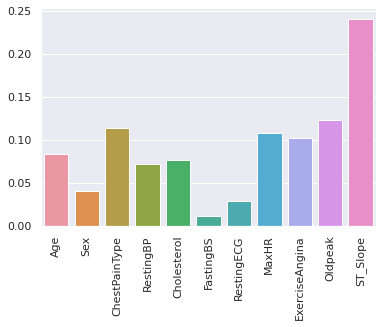

In [26]:
p=sns.barplot(x=df.columns[:-2], y=rf.feature_importances_)
p = p.set_xticklabels(labels=df.columns[:-2], rotation=90)

In [ ]:
def get_oob_scores(estimator, X, y, min_trees=20, max_trees=500, step=20):
    oob_score = []
    estimator.set_params(oob_score=True, warm_start=True, random_state=12345)
    
    for i in range(min_trees, max_trees + 1, step):
        estimator.set_params(n_estimators=i)
        estimator.fit(X, y)
        oob_score.append(estimator.oob_score_)

    return pd.DataFrame({'trees': np.arange(min_trees, max_trees+1, step), 
                         'accuracy': oob_score})

In [ ]:
rf_model = RandomForestClassifier(max_features = 'sqrt')
rf_scores = get_oob_scores(rf_model, X=df.iloc[:,:-2], y=df.HeartDisease)

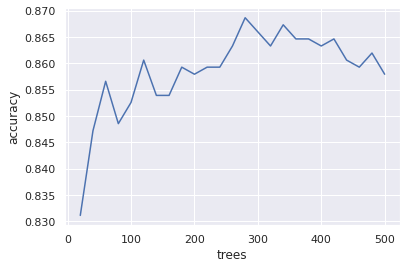

In [ ]:
sns.lineplot(x='trees', y='accuracy', data=rf_scores)

In [ ]:
m2_model = RandomForestClassifier(max_features=7)
m2_scores = get_oob_scores(m2_model, X=df.iloc[:,:-2], y=df.target)

In [ ]:
m2_scores['model'] = 'm = 7'
rf_scores['model'] = 'm = 3'

In [ ]:
all_scores = pd.concat([m2_scores, rf_scores], ignore_index=True)
all_scores.accuracy.sort_values

<bound method Series.sort_values of 0     0.833780
1     0.849866
2     0.861930
3     0.868633
4     0.867292
5     0.864611
6     0.864611
7     0.864611
8     0.864611
9     0.867292
10    0.863271
11    0.861930
12    0.863271
13    0.864611
14    0.865952
15    0.864611
16    0.865952
17    0.865952
18    0.865952
19    0.865952
20    0.864611
21    0.863271
22    0.864611
23    0.861930
24    0.861930
25    0.831099
26    0.847185
27    0.856568
28    0.848525
29    0.852547
30    0.860590
31    0.853887
32    0.853887
33    0.859249
34    0.857909
35    0.859249
36    0.859249
37    0.863271
38    0.868633
39    0.865952
40    0.863271
41    0.867292
42    0.864611
43    0.864611
44    0.863271
45    0.864611
46    0.860590
47    0.859249
48    0.861930
49    0.857909
Name: accuracy, dtype: float64>

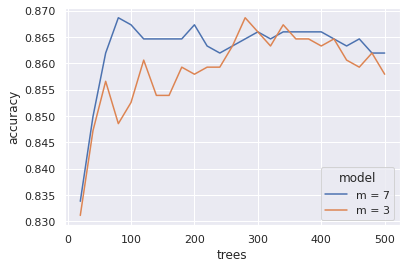

In [ ]:
sns.lineplot(x='trees', y='accuracy', hue='model', data=all_scores)

In [ ]:
from sklearn.model_selection import cross_validate
# Did Corssvaladation
random_forest = RandomForestClassifier(n_estimators = 140, max_features='sqrt')
rf_cv = cross_validate(estimator=random_forest, X=df.iloc[:,:-2], y=df.HeartDisease, scoring=["accuracy", 'roc_auc'], cv=7)
print('Accuracy = %.2f and ROC AUC = %.2f'%(rf_cv['test_accuracy'].mean(), rf_cv['test_roc_auc'].mean()))

Accuracy = 0.87 and ROC AUC = 0.92


In [ ]:
from sklearn.model_selection import cross_validate
# Did Corssvaladation
random_forest = RandomForestClassifier(n_estimators = 240, max_features='sqrt')
rf_cv = cross_validate(estimator=random_forest, X=df.iloc[:,:-2], y=df.HeartDisease, scoring=["accuracy", 'roc_auc'], cv=11)
print('Accuracy = %.2f and ROC AUC = %.2f'%(rf_cv['test_accuracy'].mean(), rf_cv['test_roc_auc'].mean()))

Accuracy = 0.87 and ROC AUC = 0.92


In [ ]:
#Logistic Regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
scalar = StandardScaler()
logistic_regression = LogisticRegression(penalty='none')
pipeline = Pipeline([('transformer', scalar), ('estimator', logistic_regression)])

In [ ]:
lr_cv = cross_validate(estimator=pipeline, X=df.iloc[:,:-2], y=df.HeartDisease, scoring=["accuracy", 'roc_auc'], cv=7)
print('Accuracy = %.2f and ROC AUC = %.2f'%(lr_cv['test_accuracy'].mean(), lr_cv['test_roc_auc'].mean()))

Accuracy = 0.84 and ROC AUC = 0.91


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
# grid search
# the pipeline integrates univarient feature selection, standardization and SVM
# serching through the best number of features to keep, the best kernals and the best parameters for the kernals
from sklearn.feature_selection import SelectKBest, f_classif

rf = RandomForestClassifier()
scaler = StandardScaler()
anova_filter = SelectKBest(f_classif)
n_range = np.linspace(1, 1000, 100).astype('int').tolist()
k_range = np.linspace(1, 10, 10).astype('int').tolist()

pipeline = Pipeline(steps = [('anova',anova_filter), ('estimator', rf)])
parameters = [
    {'anova__k': k_range,'estimator__n_estimators': n_range}
    ]



clf = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=5)
clf.fit(X = df.iloc[:,:-2], y=df.HeartDisease) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('anova', SelectKBest()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             param_grid=[{'anova__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'estimator__n_estimators': [1, 11, 21, 31, 41, 51, 61,
                                                      71, 81, 91, 101, 112, 122,
                                                      132, 142, 152, 162, 172,
                                                      182, 192, 202, 212, 223,
                                                      233, 243, 253, 263, 273,
                                                      283, 293, ...]}],
             scoring='accuracy')

In [ ]:
df.iloc[:,:-2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,0,1,140,289,0,1,172,0,0.0,2
1,49,1,2,160,180,0,1,156,0,1.0,1
2,37,0,1,130,283,0,2,98,0,0.0,2
3,48,1,0,138,214,0,1,108,1,1.5,1
4,54,0,2,150,195,0,1,122,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,1,132,0,1.2,1
914,68,0,0,144,193,1,1,141,0,3.4,1
915,57,0,0,130,131,0,1,115,1,1.2,1
916,57,1,1,130,236,0,0,174,0,0.0,1


In [133]:
select_results = pd.DataFrame(clf.cv_results_)[[ "param_estimator__n_estimators",'param_anova__k','mean_test_score','rank_test_score']]
select_results.sort_values('mean_test_score', ascending=False)

,param_estimator__n_estimators,param_anova__k,mean_test_score,rank_test_score
918,182,10,0.867248,1
942,424,10,0.863230,2
979,798,10,0.863230,2
998,989,10,0.861897,4
920,202,10,0.861897,4
...,...,...,...,...
400,1,5,0.785405,996
600,1,7,0.781512,997
900,1,10,0.772027,998
800,1,9,0.768009,999


Text(-0.19999999999999574, 0.5, 'cross-validated accuracy')

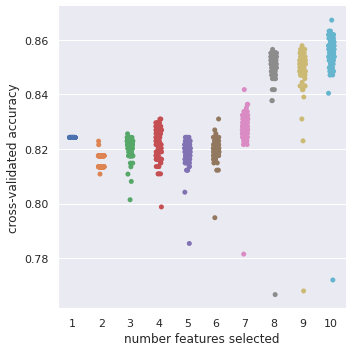

In [134]:
# the accuracy based on number of features selected
sns.catplot(x = 'param_anova__k', y ='mean_test_score', data = select_results)
mp.pyplot.xlabel('number features selected')
mp.pyplot.ylabel('cross-validated accuracy')

In [136]:
# looks like 14 features was included to score the best results, but not definatively 

anova_filter = SelectKBest(score_func = f_classif, k =10)
anova_filter.fit(df.iloc[:,:-2], y = df.iloc[:,-1])
anova_filter.scores_

array([7.28391160e+01, 6.97545245e+01, 1.38184161e+02, 2.30203087e+01,
       8.11385082e+00, 1.96960775e+01, 7.34427271e-02, 1.23425078e+02,
       3.25766789e+02, 2.42364279e+02, 4.12729588e+02])

In [142]:
# feature importance based on F-values
F_scores = pd.DataFrame(index = df.columns[:-2].tolist())
F_scores['F_scores'] = anova_filter.scores_
F_scores.sort_values('F_scores',ascending= False,inplace=True)
F_scores['rank'] = [i for i in range(1,12)]
F_scores

,F_scores,rank
ST_Slope,412.729588,1
ExerciseAngina,325.766789,2
Oldpeak,242.364279,3
ChestPainType,138.184161,4
MaxHR,123.425078,5
Age,72.839116,6
Sex,69.754525,7
RestingBP,23.020309,8
FastingBS,19.696078,9
Cholesterol,8.113851,10


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

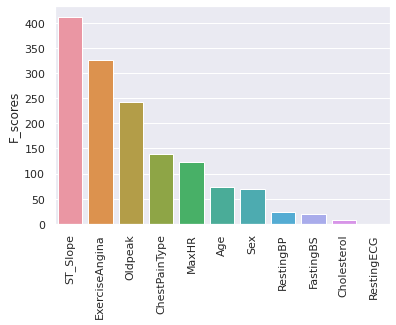

In [143]:
# Graph showing the f-scores of each feature, Keeping on the top 14 so far gave us the best performance for SVM

sns.barplot(x=F_scores.index, y = F_scores.F_scores)
#sns.set(rc = {'figure.figsize':(10,8)})
mp.pyplot. xticks(rotation =90)

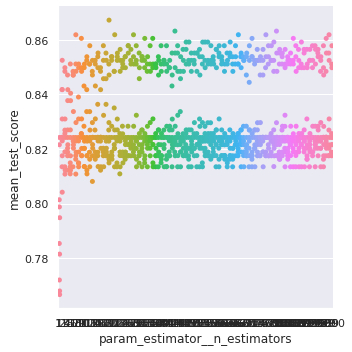

In [146]:
# accuracy based on which kernal used
sns.catplot(x = 'param_estimator__n_estimators', y ='mean_test_score', data = select_results)

In [147]:
# more detailed search
C_range = []
import numpy as np
C_range = np.linspace(0.01, 0.1,11).round(2).tolist()

for i in np.linspace(0.2, 1.1,11).round(1).tolist():
  C_range.append(i)

for i in range(10,101,10):
  C_range.append(i)

gamma_range =[]
for i in np.linspace(0.001, 0.01,10).round(3).tolist():
  gamma_range.append(i)

for i in np.linspace(0.02, 0.1,10).round(2).tolist():
  gamma_range.append(i)

for i in np.linspace(0.1, 0.2,10).round(2).tolist():
  gamma_range.append(i)
gamma_range


[0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2]

In [148]:
degree_range = np.linspace(2,10,9).astype(int).tolist()
degree_range

[2, 3, 4, 5, 6, 7, 8, 9, 10]

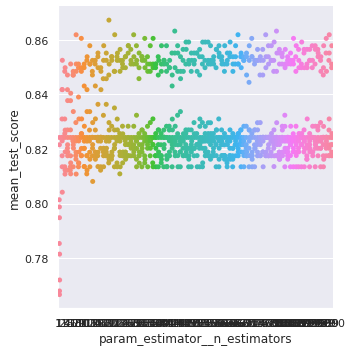

In [153]:
sns.catplot(x = 'param_estimator__n_estimators', y ='mean_test_score', data = select_results)

In [149]:
# the best model parameter
svc = SVC(kernel= 'rbf', C=0.6, gamma= 0.13)
scaler = StandardScaler()
pipe = Pipeline(steps = [('scaler', scaler), ('estimator', svc)])
from sklearn.model_selection import cross_validate as cross_val 
cross_val_data = cross_val(pipe, X = df.iloc[:,:-1], y = df.HeartDisease, cv = 5, scoring='accuracy')

In [150]:
cross_val_data['test_score'].mean()

0.9946308724832214